<a href="https://colab.research.google.com/github/nathanaelsee/diffplasticity-RNN/blob/master/diffplastRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Differentiable Plasticity RNN
## An Extension of Uber's Differentiable Plasticity:
https://github.com/uber-research/differentiable-plasticity/

Testing the effectiveness of the differentiable plasticity network as an RNN model

## Examples/tutorials used:

https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html  
https://jovianlin.io/pytorch-with-gpu-in-google-colab/  

# Install PyTorch

In [1]:
!pip3 install http://download.pytorch.org/whl/cu92/torch-0.4.1-cp36-cp36m-linux_x86_64.whl
    
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
from torch.autograd import Variable

print("PyTorch version:", torch.__version__)
print("CUDA version:\t", torch.version.cuda)

    100% |████████████████████████████████| 512.6MB 51.9MB/s 
tcmalloc: large alloc 1073750016 bytes == 0x58928000 @  0x7f92c313d2a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
PyTorch version: 0.4.1
CUDA version:	 9.2.148


# Build the model

Credits to Uber: https://github.com/uber-research/differentiable-plasticity/  
Modifications made to original sample code.

In [0]:
class DiffPlastRNN(nn.Module):
    def __init__(self, input_size, num_classes):
        
        super(DiffPlastRNN, self).__init__()
        self.input_size  = input_size
        
        # Initialize trainable parameters
        self.w     = nn.Parameter(.01 * torch.randn(input_size, input_size), requires_grad=True) # The matrix of fixed (baseline) weights
        self.alpha = nn.Parameter(.01 * torch.randn(input_size, input_size), requires_grad=True) # The matrix of plasticity coefficients
        self.eta   = nn.Parameter(.01 * torch.ones(1),                       requires_grad=True) # The "learning rate" of plasticity - scalar-valued
        
        self.mlp = nn.Linear(input_size, num_classes) # MLP on top of hidden state for classification
        self.softmax = nn.LogSoftmax(dim=1)           # Softmax layer on classification

    # Run the network for one timestep
    def forward(self, input, x_in, hebb):
        
        # hidden state - using tanh as non-linearity, as per paper
        x_out = torch.tanh( x_in.mm(self.w + torch.mul(self.alpha, hebb)) + input )
        
        # Hebbian trace
        hebb = (1 - self.eta) * hebb + self.eta * torch.bmm(x_in.unsqueeze(2), x_out.unsqueeze(1))[0] 
        # bmm here is used to implement an outer product between yin and yout, with the help of unsqueeze (i.e. added empty dimensions)
        
        # log softmax output for classification
        output = self.softmax(self.mlp(x_out))
        
        return x_out, hebb, output

    # RuntimeError if not using CUDA
    def checkCuda(self):
        self.w.get_device()
        self.alpha.get_device()
        self.eta.get_device()
        
    # Return an initialized, all-zero hidden state
    def initialZeroState(self):
        return torch.zeros(1, self.input_size)

    # Return an initialized, all-zero Hebbian trace
    def initialZeroHebb(self):
        return torch.zeros(self.input_size, self.input_size)

# Download & Process Dataset

Dataset of names and their lingustic backgrounds taken from https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html

In [3]:
!wget https://download.pytorch.org/tutorial/data.zip
!unzip data.zip

--2018-12-06 01:42:48--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 54.192.151.98, 54.192.151.109, 54.192.151.21, ...
Connecting to download.pytorch.org (download.pytorch.org)|54.192.151.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  8.83MB/s    in 0.3s    

2018-12-06 01:42:49 (8.83 MB/s) - ‘data.zip’ saved [2882130/2882130]

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/I

In [4]:
from __future__ import unicode_literals, division
from io import open
import glob
import os
import unicodedata
import string
import random

all_letters = string.ascii_letters + " .,;'"

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    ).lower()

def letterToIndex(letter):
    return all_letters.find(letter)

print('Ślusàrski ->', unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_lines = []
line_table = []
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

category_id = 0
for filename in glob.glob('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines
    table = [(line, category_id) for line in lines]
    all_lines += lines
    line_table += table
    category_id += 1

n_data = len(all_lines)

def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

random.shuffle(line_table)

# Split data into training and test sets
ratio = 0.8
n_training = int(n_data * ratio)
n_test = n_data - n_training

training_set = line_table[:n_training]
test_set = line_table[n_training:]
training_dict = dict(training_set)
test_dict = dict(test_set)

print(all_categories)
print(category_lines['Italian'][:5])
print("Input dataset size:", n_data)
print("Training set size:", len(training_set))
print("Test set size:", len(test_set))

Ślusàrski -> slusarski
['Portuguese', 'Scottish', 'German', 'Vietnamese', 'Italian', 'English', 'Greek', 'Dutch', 'Irish', 'French', 'Spanish', 'Korean', 'Arabic', 'Czech', 'Chinese', 'Russian', 'Polish', 'Japanese']
['abandonato', 'abatangelo', 'abatantuono', 'abate', 'abategiovanni']
Input dataset size: 20074
Training set size: 16059
Test set size: 4015


# Initialize Network with Hyperparameters

In [5]:
# Hyperparameters
n_letters = len(all_letters)
n_categories = len(all_categories)
learning_rate = 0.001

# Initialize net & training settings
net = DiffPlastRNN(n_letters, n_categories)
loss_func = nn.NLLLoss() # negative log likelihood loss
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate) # Adam optimizer - more nuanced than basic grad desc

# Enable CUDA if available
use_cuda = True
if use_cuda and torch.cuda.is_available():
    net.cuda()
    net.checkCuda()
    print("Using CUDA!")
else:
    net.cpu()
    print("Using CPU!")

Using CUDA!


# Define training & predicting methods

In [0]:
def getTrainingExample(index):
    line, category_id = training_set[index]
    category = all_categories[category_id]
    category_tensor = torch.tensor([category_id], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor.cuda(), line_tensor.cuda()

def getTestExample(index):
    line, category_id = test_set[index]
    category = all_categories[category_id]
    category_tensor = torch.tensor([category_id], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor.cuda(), line_tensor.cuda()

def train(category_tensor, line_tensor):
    x_in = net.initialZeroState().cuda()
    hebb = net.initialZeroHebb().cuda()

    net.zero_grad()

    for i in range(line_tensor.size()[0]):
        x_in, hebb, output = net(line_tensor[i], x_in, hebb)

    loss = loss_func(output, category_tensor)
    loss.backward()
    optimizer.step()

    return output, loss.item()

def test(category_tensor, line_tensor):
    x_in = net.initialZeroState().cuda()
    hebb = net.initialZeroHebb().cuda()

    for i in range(line_tensor.size()[0]):
        x_in, hebb, output = net(line_tensor[i], x_in, hebb)

    loss = loss_func(output, category_tensor)
    return output, loss.item()

def evaluate(line_tensor):
    x_in = net.initialZeroState().cuda()
    hebb = net.initialZeroHebb().cuda()

    for i in range(line_tensor.size()[0]):
        x_in, hebb, output = net(line_tensor[i], x_in, hebb)

    return output

def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        line = unicodeToAscii(input_line)
        
        if line in training_dict:
            print(line, "found in training dataset, category", all_categories[training_dict['line']])
        else:
            print(line, "not found in training dataset")
        
        output = evaluate(lineToTensor(line).cuda())

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

# Train Model on Training Set

In [0]:
import time
import math

def categoryFromOutput(output):
    top_n, top_i = output.data.topk(1) # Tensor out of Variable with .data
    category_i = top_i[0][0]
    return all_categories[category_i], category_i

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [8]:
# Train
start = time.time()

training_losses = []

n_iters = n_training
print_every = n_iters // 10
plot_every = n_iters // 100

print_loss = 0
plot_loss = 0

for iter in range(0, n_iters):
    category, line, category_tensor, line_tensor = getTrainingExample(iter)
    output, loss = train(category_tensor, line_tensor)
    print_loss += loss
    plot_loss += loss

    # Print iter number, loss, name and guess
    if (iter + 1) % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d\t%d%%\t(%s) \t%.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), print_loss / print_every, line, guess, correct))
        print_loss = 0

    # Add current loss avg to list of losses
    if (iter + 1) % plot_every == 0:
        training_losses.append(plot_loss / plot_every)
        plot_loss = 0

1604	9%	(0m 24s) 	1.8618 issa / English ✗ (Arabic)
3209	19%	(0m 49s) 	1.5622 avinov / Russian ✓
4814	29%	(1m 14s) 	1.4374 agostini / English ✗ (Italian)
6419	39%	(1m 39s) 	1.3379 hilyuk / Russian ✓
8024	49%	(2m 4s) 	1.2785 voigt / English ✗ (German)
9629	59%	(2m 28s) 	1.1764 vann / English ✗ (Dutch)
11234	69%	(2m 53s) 	1.1732 birut / Arabic ✗ (Russian)
12839	79%	(3m 19s) 	1.1291 morcos / English ✗ (Arabic)
14444	89%	(3m 44s) 	1.0852 elfman / English ✓
16049	99%	(4m 8s) 	1.0510 mustafa / Russian ✗ (Arabic)


In [12]:
# Test
start = time.time()

n_iters = n_test
total_test_loss = 0

for iter in range(0, n_iters):
    category, line, category_tensor, line_tensor = getTestExample(iter)
    output, loss = test(category_tensor, line_tensor)
    total_test_loss += loss

test_loss = total_test_loss / n_test
print("Test loss:", test_loss)

1.1114583170131906


# Plot training loss
Horizontal line is test loss

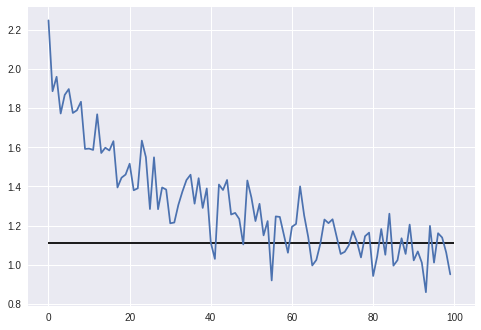

In [15]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(training_losses)
plt.hlines(test_loss, 0, 100)

#torch.save(net.state_dict(), 'model.pkl')

In [11]:
predict('Dovesky')
predict('Jackson')
predict('Satoshi')




> Dovesky
dovesky not found in training dataset
(-0.11) Russian
(-3.04) English
(-4.03) Czech

> Jackson
jackson not found in training dataset
(-0.58) Russian
(-1.24) English
(-2.66) Arabic

> Satoshi
satoshi not found in training dataset
(-0.53) Arabic
(-2.33) Japanese
(-2.54) Italian
